In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-91446af7-73e7-2206-7b88-0f6414661245)


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [4]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [5]:
# Using the 20k dataset to train our models
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
# import os

# filenames = [data_dir + filename for filename in os.listdir(data_dir)]
# filenames

In [7]:
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [8]:
# train_lines = get_lines(data_dir + "train.txt")
# train_lines[:20]

In [9]:
def preprocess_text_with_line_numbers(filename):
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = ""
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [10]:
# Get all data and preprocess them
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
# len(train_samples), len(val_samples), len(test_samples)

CPU times: user 356 ms, sys: 94.2 ms, total: 451 ms
Wall time: 479 ms


In [11]:
# train_samples[:10]

In [12]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(10)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


<Axes: ylabel='Frequency'>

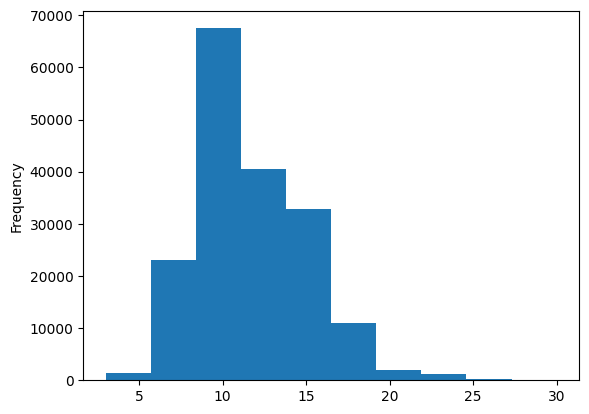

In [14]:
train_df.total_lines.plot.hist()

In [15]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
# len(train_sentences), len(val_sentences), len(test_sentences)

In [16]:
# delete ???
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [17]:
# Extract labels and encode them into integers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# train_labels_encoded

In [18]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0:  TF-IDF Multinomial Naive Baye (Baseline model)

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

model_0.fit(X=train_sentences,
            y=train_labels_encoded);

In [20]:
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [21]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [22]:
# calculate accuracy, precision, recall, and f1 score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [23]:
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 1: Conv1D with token embeddings

Prepare our data for deep sequence models:
- text vectorizer
- text embedding
- batch & prefetch





In [24]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([1.5999e+05, 1.8760e+04, 1.1510e+03, 9.9000e+01, 2.8000e+01,
        1.0000e+01, 2.0000e+00]),
 array([  1.        ,  43.14285714,  85.28571429, 127.42857143,
        169.57142857, 211.71428571, 253.85714286, 296.        ]),
 <BarContainer object of 7 artists>)

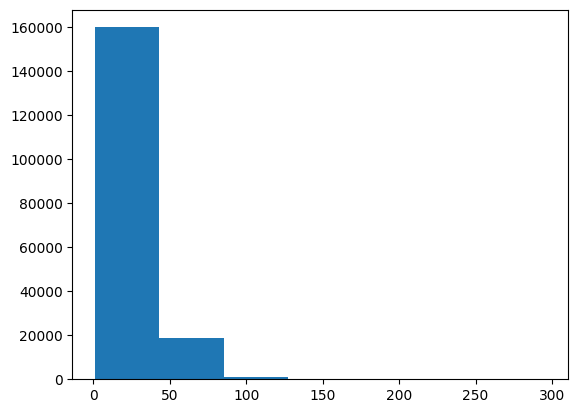

In [25]:
import matplotlib.pyplot as plt

plt.hist(sent_lens, bins=7)

In [26]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

### Create text vectorizer

In [27]:
# Section 3.2 of the PubMed 200k RCT paper states the vocabulary size of the PubMed 20k dataset as 68,000. (source: https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [28]:
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=55)

In [29]:
text_vectorizer.adapt(train_sentences)

In [30]:
import random

target_sentence = random.choice(train_sentences)
# print(f"Text:\n{target_sentence}")
# print(f"\nLength of text: {len(target_sentence.split())}")
# print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

In [31]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
# print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),
# print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
# print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

In [32]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Create token embedding layer

In [33]:
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding")


# print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
# print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
# print(f"Sentence after embedding:\n{embedded_sentence}\n")
# print(f"Embedded sentence shape: {embedded_sentence.shape}")

### Batch & Prefetch

In [34]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [35]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [36]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

In [37]:
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [38]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [39]:
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 59s 104ms/step - loss: 0.9119 - accuracy: 0.6390 - val_loss: 0.6891 - val_accuracy: 0.7364
Epoch 2/3
562/562 [==============================] - 54s 97ms/step - loss: 0.6630 - accuracy: 0.7519 - val_loss: 0.6391 - val_accuracy: 0.7650
Epoch 3/3
562/562 [==============================] - 54s 96ms/step - loss: 0.6235 - accuracy: 0.7717 - val_loss: 0.6028 - val_accuracy: 0.7826


In [40]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.6037 - accuracy: 0.7840


[0.6037232875823975, 0.7839600443840027]

In [41]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

array([[4.1207495e-01, 1.8263936e-01, 8.8500947e-02, 2.9032534e-01,
        2.6459400e-02],
       [4.2783785e-01, 3.0372655e-01, 1.2893320e-02, 2.4849482e-01,
        7.0475293e-03],
       [1.8452525e-01, 9.4242543e-03, 2.4698330e-03, 8.0353147e-01,
        4.9213369e-05],
       ...,
       [3.1434715e-06, 7.0031756e-04, 5.5766944e-04, 2.3775826e-06,
        9.9873656e-01],
       [5.1653784e-02, 4.6412545e-01, 9.7646646e-02, 6.9284514e-02,
        3.1728965e-01],
       [1.6022451e-01, 6.7727751e-01, 3.4717992e-02, 5.0025467e-02,
        7.7754565e-02]], dtype=float32)

In [42]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [43]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.39600158877266,
 'precision': 0.7803888032967392,
 'recall': 0.7839600158877267,
 'f1': 0.7813738742976907}

In [44]:
# Compare new model to the baseline model
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

In [45]:
compare_baseline_to_new_results(baseline_results, model_1_results)

Baseline accuracy: 72.18, New accuracy: 78.40, Difference: 6.21
Baseline precision: 0.72, New precision: 0.78, Difference: 0.06
Baseline recall: 0.72, New recall: 0.78, Difference: 0.06
Baseline f1: 0.70, New f1: 0.78, Difference: 0.08


## Model 2: Feature extraction with pretrained token embeddings

In [46]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [47]:
# random_training_sentence = random.choice(train_sentences)
# print(f"Random training sentence:\n{random_training_sentence}\n")
# use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
# print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
# print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

In [48]:
# pip install tensorflow==2.8.0 # debug

In [50]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(5, activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

In [51]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [52]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 5)                 645       
                                                           

In [53]:
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 9s 13ms/step - loss: 0.8778 - accuracy: 0.6537 - val_loss: 0.7466 - val_accuracy: 0.7151
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.7223 - accuracy: 0.7207 - val_loss: 0.6974 - val_accuracy: 0.7334
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7031 - accuracy: 0.7268 - val_loss: 0.6690 - val_accuracy: 0.7473


In [54]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 8s 8ms/step - loss: 0.6844 - accuracy: 0.7389


[0.6844335198402405, 0.738878607749939]

In [55]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[5.2434802e-01, 1.6497539e-01, 1.9068335e-03, 3.0623987e-01,
        2.5298784e-03],
       [3.3688653e-01, 5.4325300e-01, 3.0172118e-03, 1.1511035e-01,
        1.7329578e-03],
       [1.9041859e-01, 1.9240920e-02, 2.0651000e-02, 7.6448506e-01,
        5.2044378e-03],
       ...,
       [9.4509637e-04, 2.9455756e-03, 8.8154234e-02, 4.8646794e-04,
        9.0746862e-01],
       [7.7473256e-03, 5.7233524e-02, 2.5477904e-01, 3.6334835e-03,
        6.7660660e-01],
       [5.1836318e-01, 4.2813003e-01, 4.1995127e-02, 8.5248407e-03,
        2.9868609e-03]], dtype=float32)

In [56]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 0])>

In [57]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 73.88785912882298,
 'precision': 0.7407885552210985,
 'recall': 0.7388785912882299,
 'f1': 0.7385185023461805}

In [58]:
compare_baseline_to_new_results(baseline_results=baseline_results,
                                new_model_results=model_2_results)

Baseline accuracy: 72.18, New accuracy: 73.89, Difference: 1.70
Baseline precision: 0.72, New precision: 0.74, Difference: 0.02
Baseline recall: 0.72, New recall: 0.74, Difference: 0.02
Baseline f1: 0.70, New f1: 0.74, Difference: 0.04


## Model 3: Conv1D with character embeddings

### Create character-level tokenizer

In [59]:
def split_chars(text):
  return " ".join(list(text))

In [60]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
# print(train_chars[0])

In [61]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

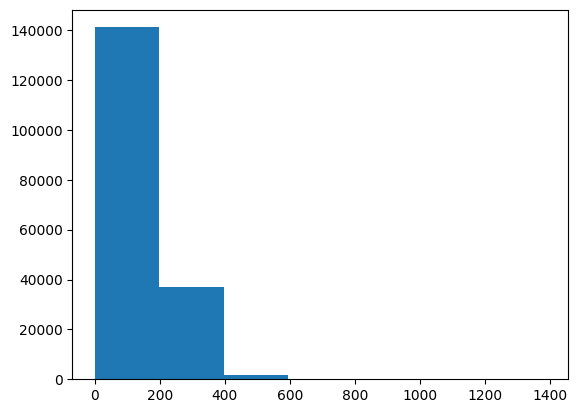

In [62]:
import matplotlib.pyplot as plt

plt.hist(char_lens, bins=7)

In [63]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [65]:
# Get all keyboard characters for char-level embedding
import string

alphabet = string.ascii_lowercase + string.digits + string.punctuation

In [66]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

char_vectorizer.adapt(train_chars)

In [67]:
char_vocab = char_vectorizer.get_vocabulary()
# print(f"Number of different characters in character vocab: {len(char_vocab)}")
# print(f"5 most common characters: {char_vocab[:5]}")
# print(f"5 least common characters: {char_vocab[-5:]}")

In [68]:
random_train_chars = random.choice(train_chars)
# print(f"Charified text:\n{random_train_chars}")
# print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
# print(f"\nVectorized chars:\n{vectorized_chars}")
# print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

### Create char embedding layer

In [70]:
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False,
                              name="char_embed")

# print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
# char_embed_example = char_embed(char_vectorizer([random_train_chars]))
# print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
# print(f"Character embedding shape: {char_embed_example.shape}")

### Batch & Prefetch

In [74]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

# train_char_dataset

In [71]:
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

In [72]:
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [73]:
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_7 (Dense)             (None, 5

In [75]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 19ms/step - loss: 1.2597 - accuracy: 0.4855 - val_loss: 1.0303 - val_accuracy: 0.6007
Epoch 2/3
562/562 [==============================] - 11s 19ms/step - loss: 0.9848 - accuracy: 0.6094 - val_loss: 0.9134 - val_accuracy: 0.6443
Epoch 3/3
562/562 [==============================] - 10s 17ms/step - loss: 0.9047 - accuracy: 0.6455 - val_loss: 0.8482 - val_accuracy: 0.6789


In [76]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 6s 6ms/step - loss: 0.8648 - accuracy: 0.6685


[0.8648298978805542, 0.6685091853141785]

In [77]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.21123497, 0.2896947 , 0.08025463, 0.3184359 , 0.10037987],
       [0.40534672, 0.34691286, 0.01861491, 0.18053873, 0.04858674],
       [0.0768351 , 0.23384728, 0.15528   , 0.48776534, 0.04627222],
       ...,
       [0.00688335, 0.02272597, 0.1476254 , 0.01697197, 0.8057933 ],
       [0.03853926, 0.26819876, 0.2622206 , 0.03925323, 0.3917881 ],
       [0.6019503 , 0.25523052, 0.08098049, 0.05457992, 0.00725878]],
      dtype=float32)

In [78]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 0, 3, ..., 4, 4, 0])>

In [79]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 66.85092016417317,
 'precision': 0.6626430588407695,
 'recall': 0.6685092016417318,
 'f1': 0.6606072962155384}

In [80]:
compare_baseline_to_new_results(baseline_results=baseline_results,
                                new_model_results=model_3_results)

Baseline accuracy: 72.18, New accuracy: 66.85, Difference: -5.33
Baseline precision: 0.72, New precision: 0.66, Difference: -0.06
Baseline recall: 0.72, New recall: 0.67, Difference: -0.05
Baseline f1: 0.70, New f1: 0.66, Difference: -0.04


## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

In [85]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# train_char_token_dataset, val_char_token_dataset

In [81]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [89]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [90]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

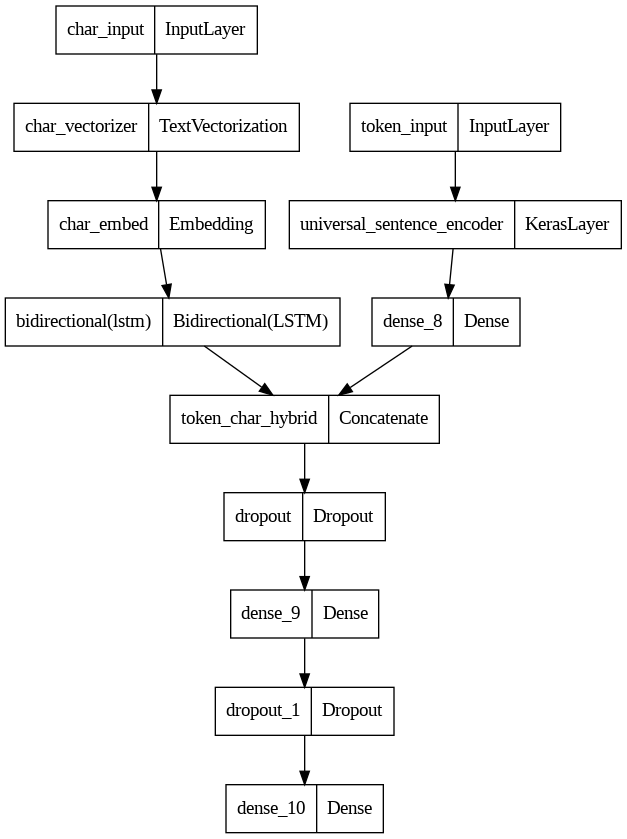

In [91]:
from tensorflow.keras.utils import plot_model

plot_model(model_4)

In [92]:
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 134s 231ms/step - loss: 0.9386 - accuracy: 0.6304 - val_loss: 0.7821 - val_accuracy: 0.7061
Epoch 2/3
562/562 [==============================] - 125s 222ms/step - loss: 0.7934 - accuracy: 0.6948 - val_loss: 0.7124 - val_accuracy: 0.7320
Epoch 3/3
562/562 [==============================] - 127s 226ms/step - loss: 0.7660 - accuracy: 0.7087 - val_loss: 0.6898 - val_accuracy: 0.7414


In [93]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 48s 51ms/step - loss: 0.6926 - accuracy: 0.7338


[0.6926167607307434, 0.7338474988937378]

In [94]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[3.9766183e-01, 3.8886014e-01, 2.7163115e-03, 2.0242268e-01,
        8.3390148e-03],
       [3.2740736e-01, 4.8741579e-01, 3.2007054e-03, 1.7824790e-01,
        3.7283499e-03],
       [3.1210488e-01, 1.4089003e-01, 3.1153331e-02, 4.8272145e-01,
        3.3130299e-02],
       ...,
       [3.9286749e-04, 5.7214024e-03, 3.8258422e-02, 1.1947277e-04,
        9.5550787e-01],
       [6.1277356e-03, 4.9096238e-02, 1.9404744e-01, 2.4551661e-03,
        7.4827337e-01],
       [3.2158330e-01, 4.5980328e-01, 1.2870519e-01, 4.2506583e-02,
        4.7401629e-02]], dtype=float32)

In [95]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [96]:
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.38474778233814,
 'precision': 0.7348414160359401,
 'recall': 0.7338474778233814,
 'f1': 0.7311431734169948}

In [97]:
compare_baseline_to_new_results(baseline_results=baseline_results,
                                new_model_results=model_4_results)

Baseline accuracy: 72.18, New accuracy: 73.38, Difference: 1.20
Baseline precision: 0.72, New precision: 0.73, Difference: 0.02
Baseline recall: 0.72, New recall: 0.73, Difference: 0.01
Baseline f1: 0.70, New f1: 0.73, Difference: 0.03


## Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

### Create positional embeddings

In [98]:
train_df["line_number"].value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


<Axes: ylabel='Frequency'>

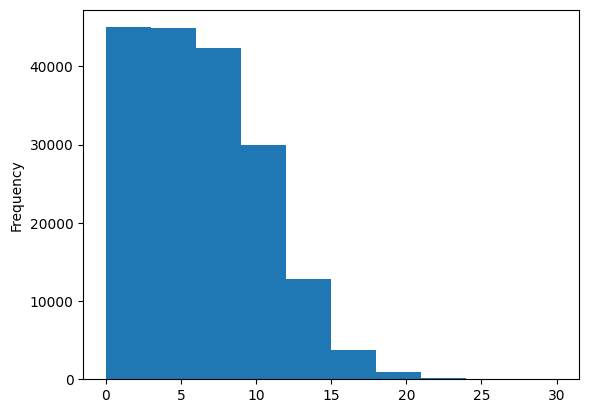

In [99]:
train_df.line_number.plot.hist()

In [100]:
# Create one-hot-encoded tensors of "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [101]:
train_df["total_lines"].value_counts()

,count
total_lines,
11,24468
10,23639
12,22113
9,19400
13,18438
14,14610
8,12285
15,10768
7,7464


<Axes: ylabel='Frequency'>

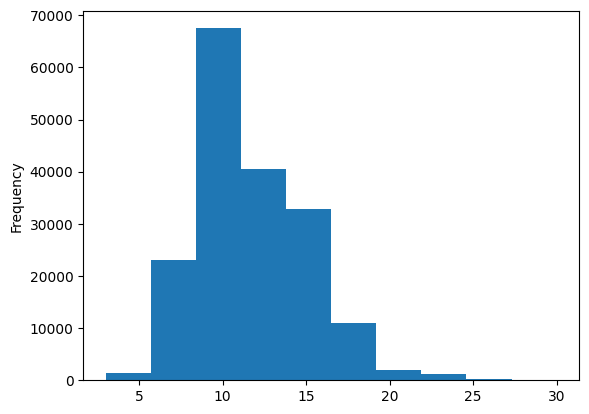

In [102]:
train_df.total_lines.plot.hist()

In [103]:
np.percentile(train_df.total_lines, 98)

20.0

In [104]:
# Create one-hot-encoded tensors of "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

In [109]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# train_pos_char_token_dataset, val_pos_char_token_dataset

In [105]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [106]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [107]:
model_5.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

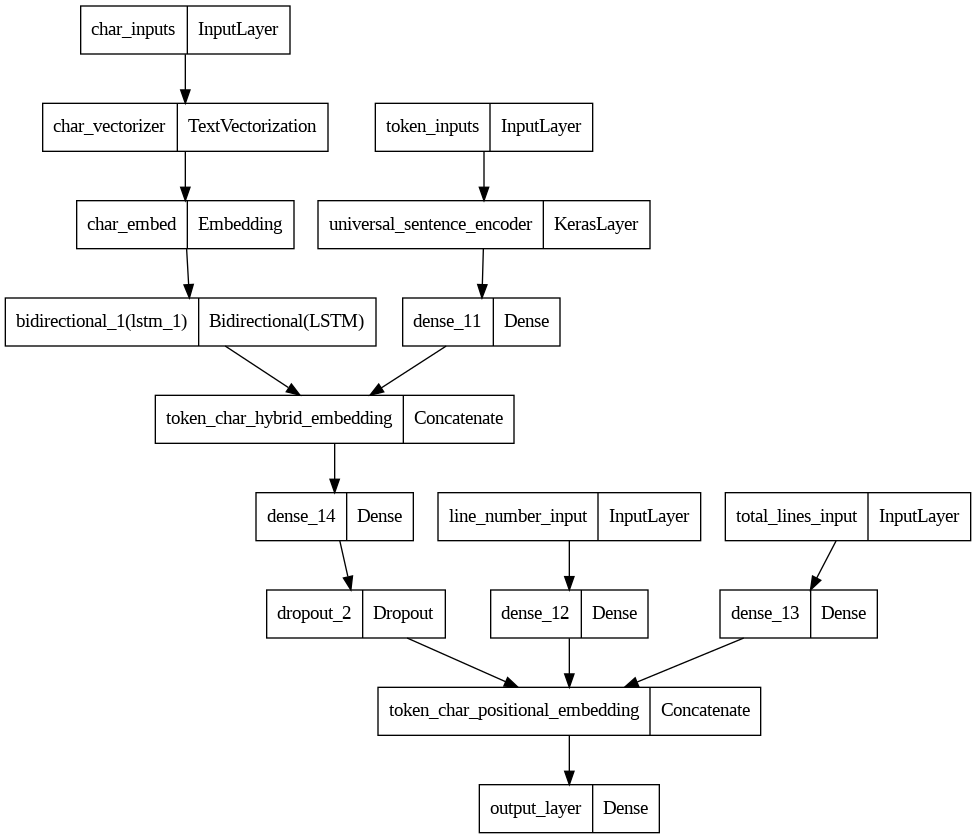

In [108]:
from tensorflow.keras.utils import plot_model

plot_model(model_5)

In [110]:
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 133s 230ms/step - loss: 1.1011 - accuracy: 0.7150 - val_loss: 0.9842 - val_accuracy: 0.8049
Epoch 2/3
562/562 [==============================] - 129s 229ms/step - loss: 0.9696 - accuracy: 0.8154 - val_loss: 0.9510 - val_accuracy: 0.8275
Epoch 3/3
562/562 [==============================] - 130s 232ms/step - loss: 0.9517 - accuracy: 0.8246 - val_loss: 0.9377 - val_accuracy: 0.8281


In [111]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 51s 53ms/step


array([[0.50038755, 0.10594389, 0.00948639, 0.36787206, 0.01631013],
       [0.5486055 , 0.09744389, 0.05295109, 0.28953913, 0.01146033],
       [0.26756784, 0.10825972, 0.13384327, 0.4161325 , 0.07419666],
       ...,
       [0.03852097, 0.09865783, 0.03239648, 0.03322959, 0.7971951 ],
       [0.03746668, 0.2789705 , 0.0683466 , 0.02908791, 0.58612835],
       [0.25370875, 0.5464925 , 0.09434288, 0.04386863, 0.0615873 ]],
      dtype=float32)

In [112]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [113]:
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.2318284125513,
 'precision': 0.8312578828507458,
 'recall': 0.832318284125513,
 'f1': 0.831077500005745}

In [114]:
compare_baseline_to_new_results(baseline_results=baseline_results,
                                new_model_results=model_5_results)

Baseline accuracy: 72.18, New accuracy: 83.23, Difference: 11.05
Baseline precision: 0.72, New precision: 0.83, Difference: 0.11
Baseline recall: 0.72, New recall: 0.83, Difference: 0.11
Baseline f1: 0.70, New f1: 0.83, Difference: 0.13


## Compare all model results

In [115]:
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.396002,0.780389,0.783960,0.781374
pretrained_token_embed,73.887859,0.740789,0.738879,0.738519
custom_char_embed_conv1d,66.850920,0.662643,0.668509,0.660607
hybrid_char_token_embed,73.384748,0.734841,0.733847,0.731143
tribrid_pos_char_token_embed,83.231828,0.831258,0.832318,0.831078


In [116]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100

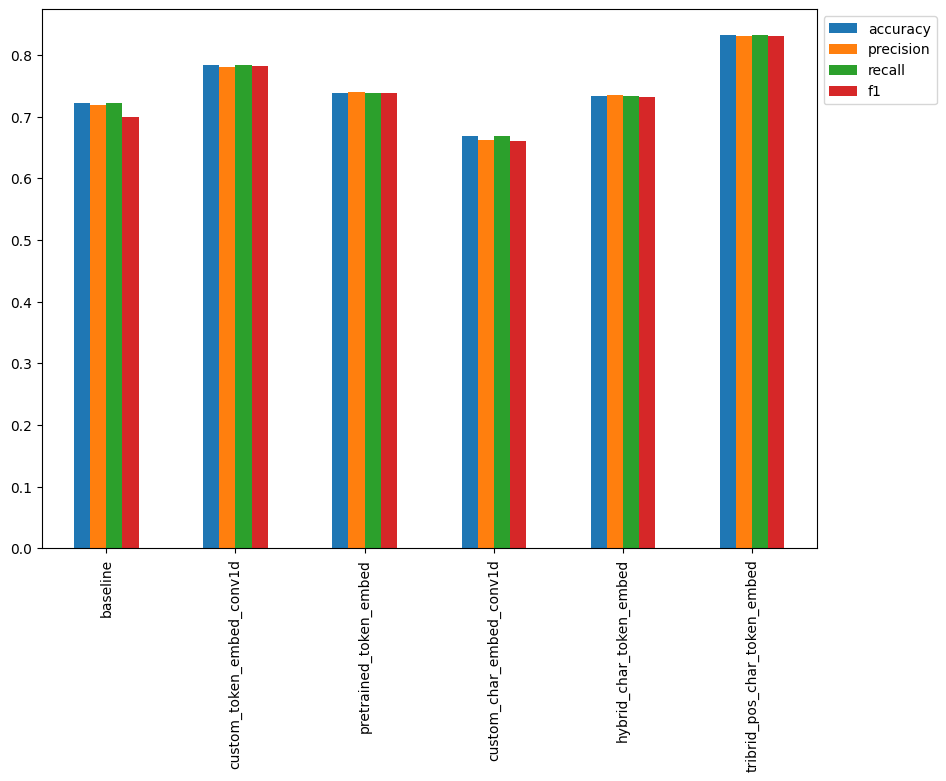

In [117]:
# Compare all results among all models
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

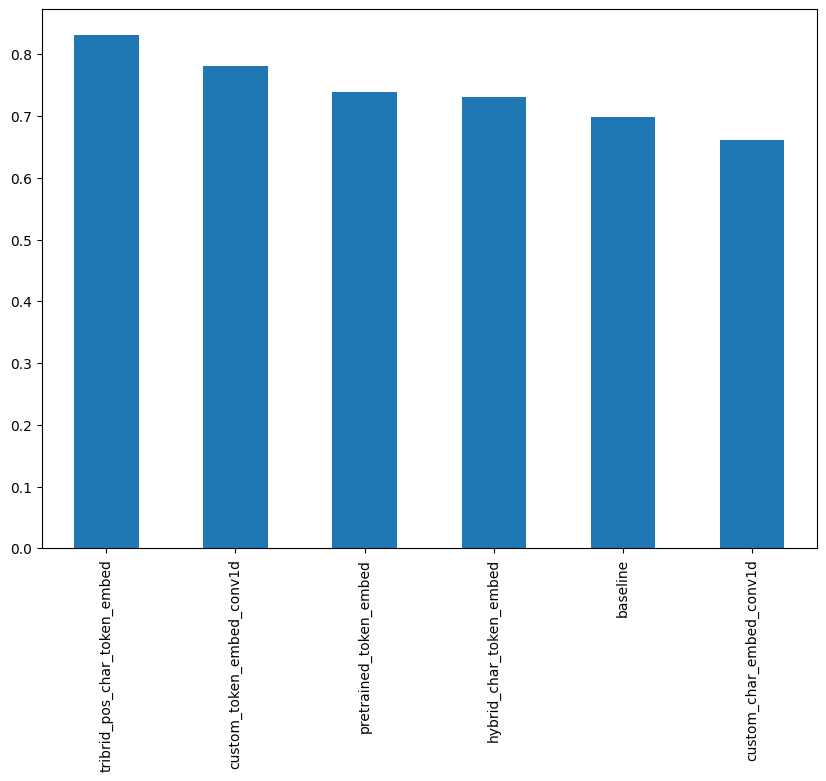

In [118]:
# Compare f1 score among all models (descending)
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

## Enhance performance by training model 5 as many epochs until it stops improving

In [120]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define ModelCheckpoint to save the best model based on validation loss
checkpoint = ModelCheckpoint("best_model.tf", monitor="val_loss",
                             save_best_only=True, verbose=1)

# Define EarlyStopping to stop training when the validation loss stops improving
early_stopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1,
                               restore_best_weights=True)

history_model_5 = model_5.fit(
    train_pos_char_token_dataset,
    steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
    epochs=100,  # Train for many epochs and rely on early stopping
    validation_data=val_pos_char_token_dataset,
    validation_steps=int(0.1 * len(val_pos_char_token_dataset)),
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/100
562/562 [==============================] - ETA: 0s - loss: 0.9185 - accuracy: 0.8495
Epoch 1: val_loss improved from inf to 0.92814, saving model to best_model.tf


562/562 [==============================] - 200s 356ms/step - loss: 0.9185 - accuracy: 0.8495 - val_loss: 0.9281 - val_accuracy: 0.8418
Epoch 2/100
562/562 [==============================] - ETA: 0s - loss: 0.9238 - accuracy: 0.8468
Epoch 2: val_loss improved from 0.92814 to 0.91938, saving model to best_model.tf


562/562 [==============================] - 161s 286ms/step - loss: 0.9238 - accuracy: 0.8468 - val_loss: 0.9194 - val_accuracy: 0.8481
Epoch 3/100
562/562 [==============================] - ETA: 0s - loss: 0.9179 - accuracy: 0.8483
Epoch 3: val_loss did not improve from 0.91938
562/562 [==============================] - 132s 235ms/step - loss: 0.9179 - accuracy: 0.8483 - val_loss: 0.9209 - val_accuracy: 0.8401
Epoch 4/100
562/562 [==============================] - ETA: 0s - loss: 0.9227 - accuracy: 0.8468
Epoch 4: val_loss improved from 0.91938 to 0.91828, saving model to best_model.tf


562/562 [==============================] - 171s 304ms/step - loss: 0.9227 - accuracy: 0.8468 - val_loss: 0.9183 - val_accuracy: 0.8424
Epoch 5/100
562/562 [==============================] - ETA: 0s - loss: 0.9244 - accuracy: 0.8429
Epoch 5: val_loss improved from 0.91828 to 0.91268, saving model to best_model.tf


562/562 [==============================] - 192s 342ms/step - loss: 0.9244 - accuracy: 0.8429 - val_loss: 0.9127 - val_accuracy: 0.8424
Epoch 6/100
562/562 [==============================] - ETA: 0s - loss: 0.9297 - accuracy: 0.8365
Epoch 6: val_loss improved from 0.91268 to 0.91239, saving model to best_model.tf


562/562 [==============================] - 193s 344ms/step - loss: 0.9297 - accuracy: 0.8365 - val_loss: 0.9124 - val_accuracy: 0.8497
Epoch 7/100
562/562 [==============================] - ETA: 0s - loss: 0.9193 - accuracy: 0.8468
Epoch 7: val_loss did not improve from 0.91239
562/562 [==============================] - 132s 234ms/step - loss: 0.9193 - accuracy: 0.8468 - val_loss: 0.9169 - val_accuracy: 0.8418
Epoch 8/100
562/562 [==============================] - ETA: 0s - loss: 0.9158 - accuracy: 0.8489
Epoch 8: val_loss improved from 0.91239 to 0.90270, saving model to best_model.tf


562/562 [==============================] - 187s 333ms/step - loss: 0.9158 - accuracy: 0.8489 - val_loss: 0.9027 - val_accuracy: 0.8534
Epoch 9/100
562/562 [==============================] - ETA: 0s - loss: 0.9186 - accuracy: 0.8478
Epoch 9: val_loss did not improve from 0.90270
562/562 [==============================] - 133s 238ms/step - loss: 0.9186 - accuracy: 0.8478 - val_loss: 0.9119 - val_accuracy: 0.8504
Epoch 10/100
562/562 [==============================] - ETA: 0s - loss: 0.9167 - accuracy: 0.8508
Epoch 10: val_loss did not improve from 0.90270
562/562 [==============================] - 131s 232ms/step - loss: 0.9167 - accuracy: 0.8508 - val_loss: 0.9043 - val_accuracy: 0.8511
Epoch 11/100
  7/562 [..............................] - ETA: 3:02 - loss: 0.9251 - accuracy: 0.8400


Epoch 11: val_loss did not improve from 0.90270
Restoring model weights from the end of the best epoch: 8.
562/562 [==============================] - 8s 13ms/step - loss: 0.9251 - accuracy: 0.8400 - val_loss: 0.9070 - val_accuracy: 0.8484
Epoch 11: early stopping


In [123]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 48s 51ms/step


array([[0.59385014, 0.08692946, 0.0136447 , 0.28558454, 0.01999125],
       [0.58773106, 0.09640388, 0.1104528 , 0.19324996, 0.01216233],
       [0.38731965, 0.10666499, 0.05829638, 0.4142291 , 0.03348992],
       ...,
       [0.03427923, 0.09064879, 0.03657088, 0.04026189, 0.79823923],
       [0.03824741, 0.40476182, 0.10987192, 0.03289242, 0.41422638],
       [0.07958915, 0.81014687, 0.04221383, 0.02519461, 0.04285562]],
      dtype=float32)

In [124]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [125]:
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 85.51899907321594,
 'precision': 0.8546987980389767,
 'recall': 0.8551899907321594,
 'f1': 0.853078867728932}

In [126]:
compare_baseline_to_new_results(baseline_results=baseline_results,
                                new_model_results=model_5_results)

Baseline accuracy: 72.18, New accuracy: 85.52, Difference: 13.34
Baseline precision: 0.72, New precision: 0.85, Difference: 0.14
Baseline recall: 0.72, New recall: 0.86, Difference: 0.13
Baseline f1: 0.70, New f1: 0.85, Difference: 0.15


## Evaluate model on test dataset

In [121]:
# Preprocess test dataset
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# test_pos_char_token_dataset

In [122]:
test_pred_probs = model_5.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
# test_preds[:10]

942/942 [==============================] - 49s 52ms/step


In [127]:
model_5_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
model_5_test_results

{'accuracy': 85.05724240915879,
 'precision': 0.8494882294125653,
 'recall': 0.8505724240915878,
 'f1': 0.8483494241712797}

In [128]:
compare_baseline_to_new_results(baseline_results=baseline_results,
                                new_model_results=model_5_results)

Baseline accuracy: 72.18, New accuracy: 85.52, Difference: 13.34
Baseline precision: 0.72, New precision: 0.85, Difference: 0.14
Baseline recall: 0.72, New recall: 0.86, Difference: 0.13
Baseline f1: 0.70, New f1: 0.85, Difference: 0.15


In [129]:
%%time
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]

CPU times: user 6.74 s, sys: 28.1 ms, total: 6.77 s
Wall time: 9.16 s


In [131]:
test_df["prediction"] = test_pred_classes
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy()
test_df["correct"] = test_df["prediction"] == test_df["target"] # Whether the prediction is right or not
test_df.head(10)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.501618,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,METHODS,0.363876,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.789369,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.761428,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.668412,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.822234,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.646678,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.620741,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.647424,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.638894,True


In [132]:
# Find top 10 most wrong samples
top_10_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:10]
top_10_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
4391,CONCLUSIONS,-lsb- netherlands trial register ( http://www....,15,15,BACKGROUND,0.959080,False
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.953825,False
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.942349,False
18720,RESULTS,non-diffuse-trickling '' ) .,8,15,BACKGROUND,0.938614,False
7281,RESULTS,the primary outcome is weight loss .,5,7,METHODS,0.914681,False
29098,BACKGROUND,an active control arm received salmeterol ( sa...,5,15,METHODS,0.910971,False
27814,BACKGROUND,secondary outcomes are patient-rated cosmesis ...,3,10,METHODS,0.909347,False
1827,CONCLUSIONS,nct@ ( clinicaltrials.gov ) .,18,18,BACKGROUND,0.907569,False
16780,METHODS,we will comply with the consort guidelines and...,16,19,BACKGROUND,0.903690,False
29692,RESULTS,repeated measures analysis of variance ( anova...,3,6,METHODS,0.903415,False


## Test out RCT's example without abstracts

In [134]:
import json

# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

# example_abstracts

--2024-09-06 16:26:08--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json.1’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2024-09-06 16:26:08 (78.0 MB/s) - ‘skimlit_example_abstracts.json.1’ saved [6737/6737]



In [135]:
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [136]:
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd
from spacy.lang.en import English

nlp = English()
sentencizer = nlp.add_pipe("sentencizer")

doc = nlp(example_abstracts[0]["abstract"])
abstract_lines = [str(sent) for sent in list(doc.sents)]
# abstract_lines

In [137]:
total_lines_in_sample = len(abstract_lines)
sample_lines = []

for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
# sample_lines

In [138]:
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]

# One-hot encode to same depth as training data
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
# test_abstract_line_numbers_one_hot

In [139]:
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]

# One-hot encode to same depth as training data
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
# test_abstract_total_lines_one_hot

In [140]:
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
# abstract_chars

In [141]:
%%time
test_abstract_pred_probs = model_5.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

CPU times: user 1.84 s, sys: 6.07 ms, total: 1.85 s
Wall time: 2.1 s


array([[0.31187117, 0.10157727, 0.03512114, 0.5222985 , 0.02913194],
       [0.08773194, 0.03687872, 0.71241933, 0.12207198, 0.04089802],
       [0.09375114, 0.0441617 , 0.72837174, 0.08726408, 0.04645132],
       [0.10034642, 0.14406295, 0.6045466 , 0.08251627, 0.06852768],
       [0.04465042, 0.09463167, 0.50370735, 0.04632258, 0.310688  ],
       [0.02812963, 0.06699871, 0.6466125 , 0.03781645, 0.22044262],
       [0.02571899, 0.16746214, 0.11536496, 0.02791178, 0.6635422 ],
       [0.01468302, 0.16296768, 0.1576713 , 0.02464428, 0.6400337 ]],
      dtype=float32)

In [142]:
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 2, 2, 4, 4])>

In [143]:
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [151]:
file_path = "summarization.txt"

for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")
  with open(file_path, "a+") as file:
      file.write(f"{test_abstract_pred_classes[i]}: {line}"+ "\n")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.


## Save our model

In [145]:
model_5.save("skimlit_tribrid_model")